# WIP

# Goal


## Main Takeaways



## Further Analysis





In [38]:
import os
import pandas as pd
import numpy as np

import pickle
import networkx as nx

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [6]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
ALL_ADJACENCY_PATH = '../data/all-votes/all_adjacency.pickle'
pal = {'republican': '#ff0000', 'democrats': '#0000ff'}
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=2, color_codes=True, rc=None)

In [229]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
all_laws['law_id'] = all_laws['vote_uri'].apply(lambda x: '_'.join(x.split('/')[4:]).split('.')[0])
all_laws['q'] = pd.to_datetime(all_laws.date).dt.quarter
all_laws['quarter'] = all_laws.apply(lambda x: '1' '-' + str(x['q']) if x['year'] % 2==0 else '2' + '-' + str(x['q']), axis=1)
print(all_laws.shape)

with open(ALL_ADJACENCY_PATH, 'rb') as handle:
    adjacencies = pickle.load(handle)
print(len(adjacencies))

(6834, 19)
6834


In [130]:
def get_metrics(a):
    m = {}
    
    m['shape'] = a.shape
    m['L'] = a.sum(axis=1).sum(axis=0)
#     m['degree'] = a.sum(axis=1)

    G = nx.Graph(a)
    eigenvalues = nx.laplacian_spectrum(G)
    m['eigenvalues'] = eigenvalues
    m['degree_centality'] = nx.degree_centrality(G)
    m['connected_components'] = len(list(nx.connected_component_subgraphs(G)))
    m['density'] = nx.density(G)
    
    return m

In [131]:
all_metrics = [(k, get_metrics(v)) for k, v in adjacencies.items()]

In [146]:
df_metrics = pd.DataFrame([x[1] for x in all_metrics])
df_metrics['law_id'] = [x[0] for x in all_metrics]
df_metrics = df_metrics.merge(all_laws)

In [147]:
df_metrics.iloc[0].T

L                                                                    8932
connected_components                                                    5
degree_centality        {0: 0.9494949494949496, 1: 0.9494949494949496,...
density                                                          0.902222
eigenvalues             [-3.907985046680551e-14, -1.4581363525844522e-...
shape                                                          (100, 100)
law_id                                   v1_105_senate_sessions_1_votes_4
congress                                                              105
date                                                           1997-01-30
democrats_no                                                            0
democrats_yes                                                          45
independent_no                                                          0
independent_yes                                                         0
month                                 

### General overview of metrics of adjacency matrices by congress

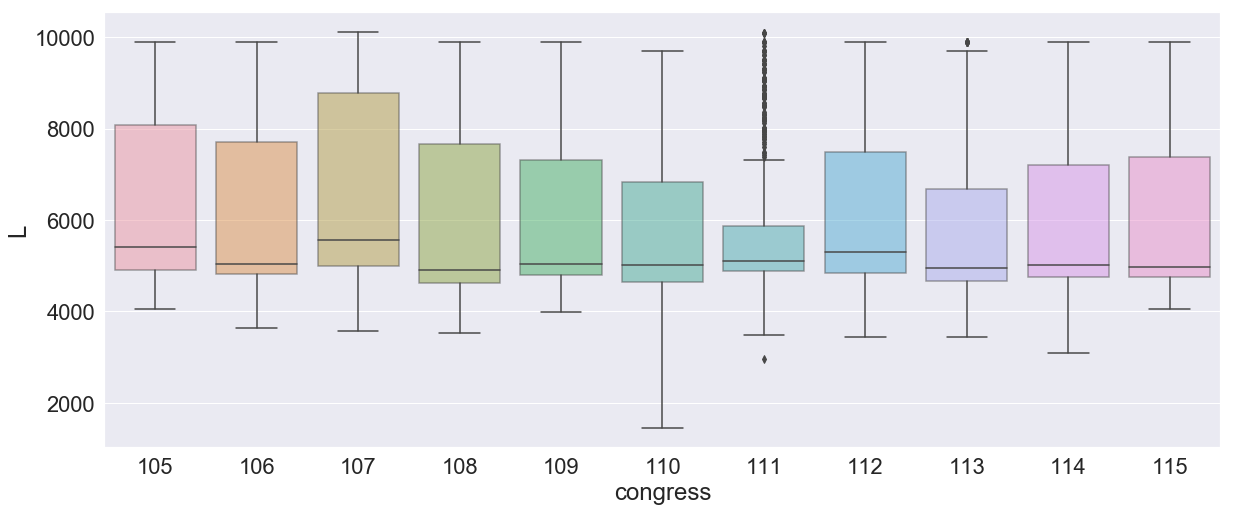

In [155]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='congress', y='L', data=df_metrics, boxprops=dict(alpha=.5))

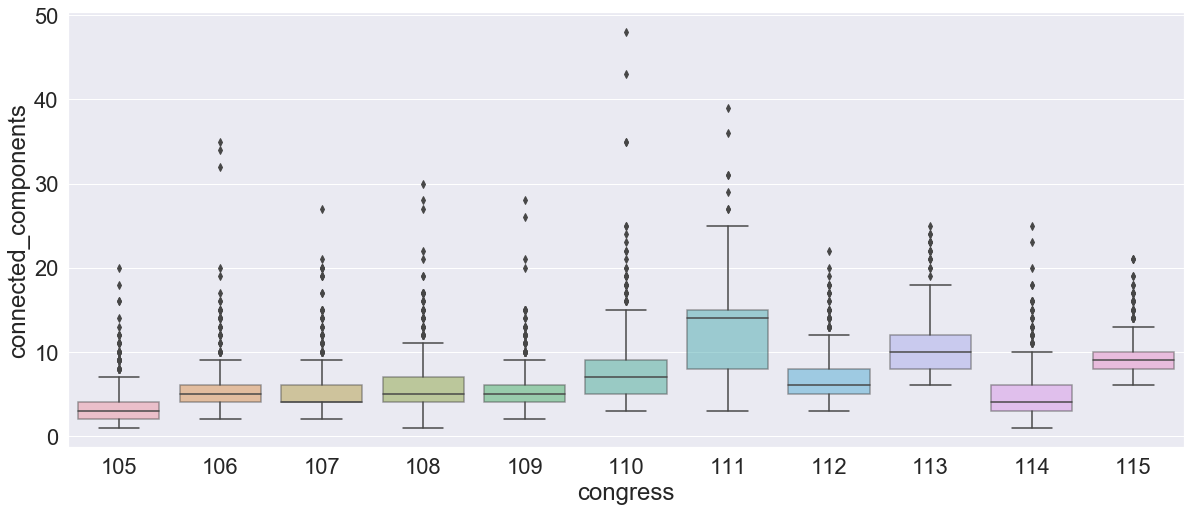

In [156]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='congress', y='connected_components', data=df_metrics, boxprops=dict(alpha=.5))

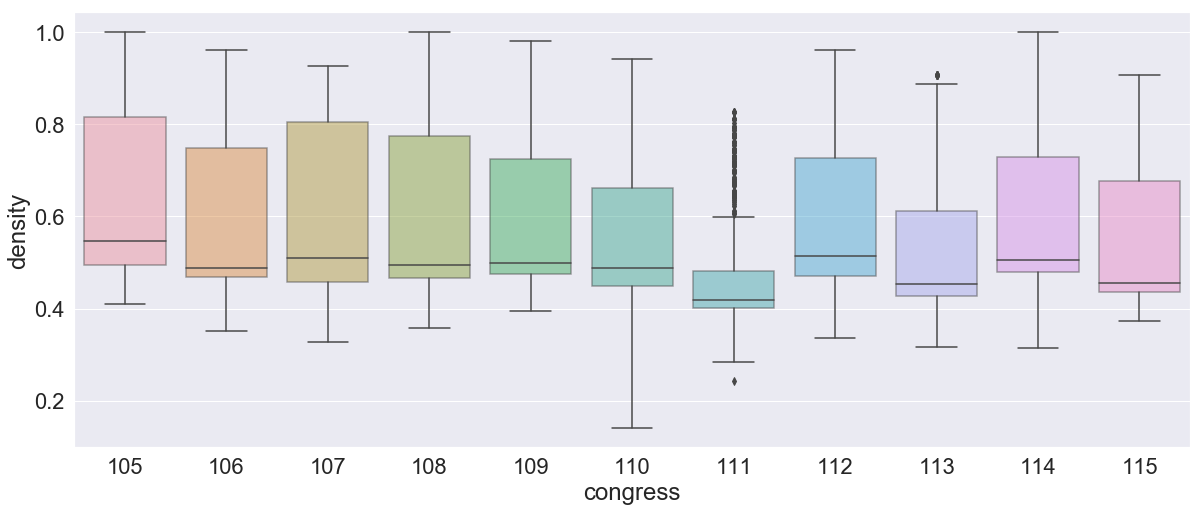

In [157]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='congress', y='density', data=df_metrics, boxprops=dict(alpha=.5))

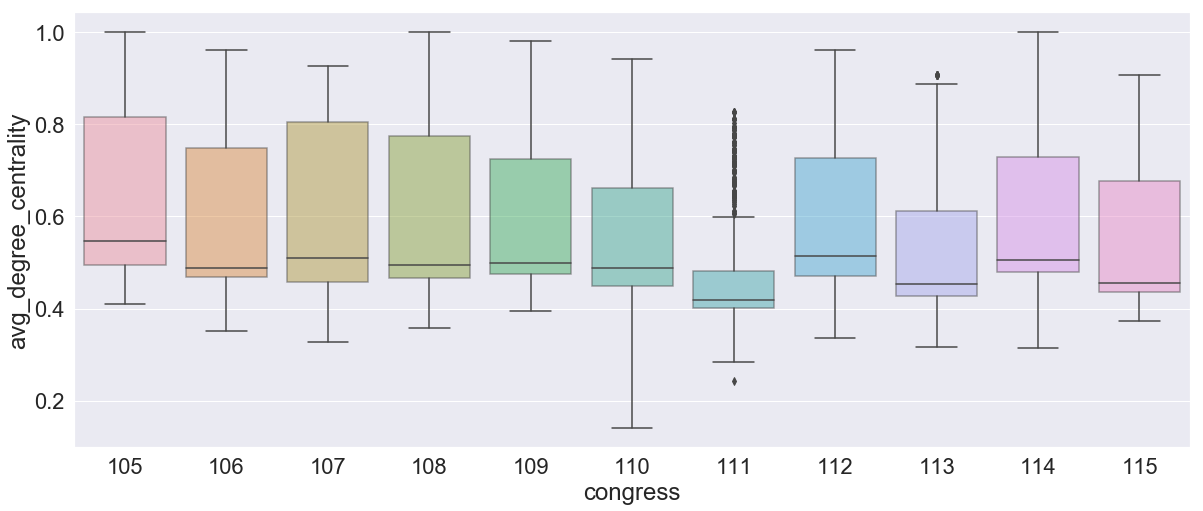

In [164]:
df_metrics['avg_degree_centrality'] = df_metrics['degree_centality'].apply(lambda x: np.mean(list(x.values())))

plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='congress', y='avg_degree_centrality', data=df_metrics, boxprops=dict(alpha=.5))

In [193]:
range_evals = 10
for i in range(0, range_evals):
    name = '{}_evalue'.format(i + 1)
    df_metrics[name] = df_metrics['eigenvalues'].apply(lambda x: x[i])
(df_metrics[['{}_evalue'.format(i + 1) for i in range(0, range_evals)]]
 .describe()
 .T[['mean', 'min', '25%', '50%', '75%', 'max']]
 .applymap(lambda x: round(x, 2)))

,mean,min,25%,50%,75%,max
1_evalue,-0.00,-0.0,-0.0,-0.0,-0.0,0.0
2_evalue,0.22,-0.0,-0.0,-0.0,-0.0,100.0
3_evalue,2.46,-0.0,-0.0,-0.0,0.0,100.0
4_evalue,6.06,-0.0,-0.0,0.0,0.0,100.0
5_evalue,10.89,-0.0,-0.0,0.0,4.0,100.0
6_evalue,15.84,-0.0,0.0,0.0,32.0,101.0
7_evalue,20.68,-0.0,0.0,3.0,41.0,101.0
8_evalue,25.71,-0.0,0.0,12.0,44.0,101.0
9_evalue,30.27,-0.0,0.0,29.0,45.0,101.0
10_evalue,34.37,-0.0,3.0,36.0,46.0,101.0


> Some congress have 102 members

### Adjacency matrices by congress and quarter

In [232]:
by = 'quarter'
quarters = sorted(all_laws[by].unique())
congress = all_laws['congress'].unique()

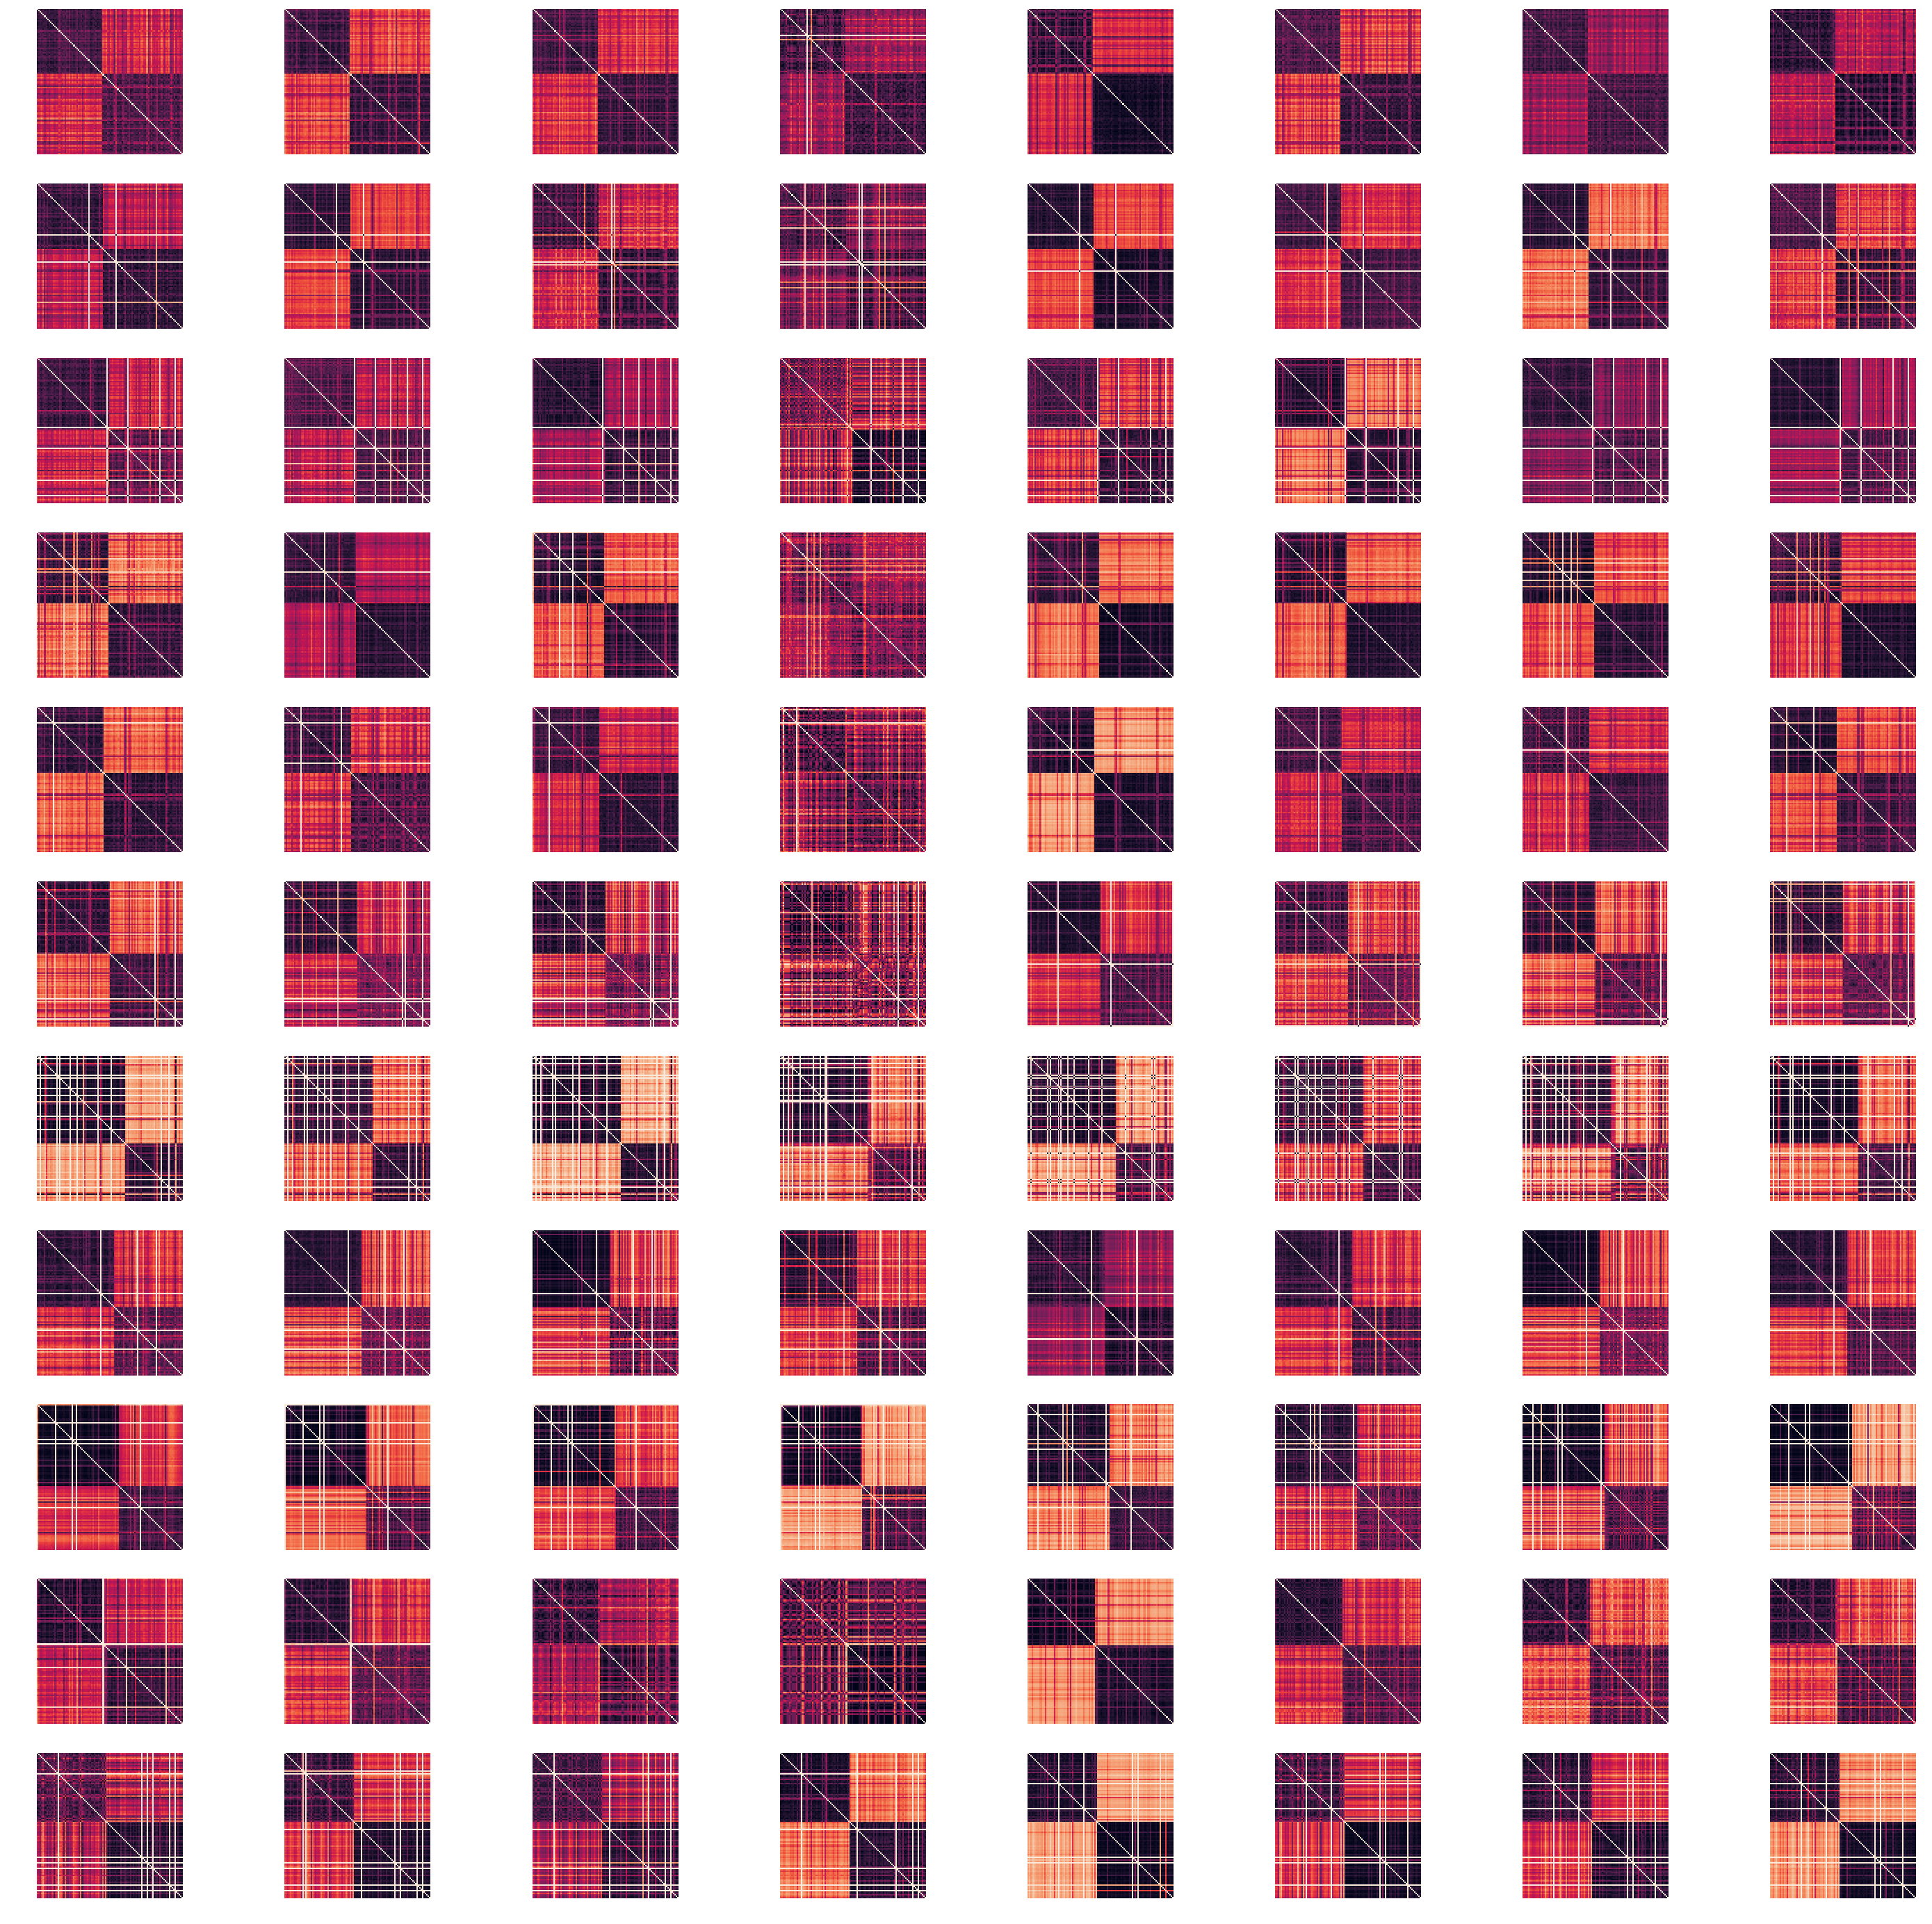

In [254]:
f, ax = plt.subplots(len(congress), len(quarters), figsize=(50, 50))

for i, c in enumerate(congress):
    for j, q in enumerate(quarters):
        laws = list(all_laws[(all_laws.quarter == q) & (all_laws.congress == c)]['law_id'])
        n = len(laws)
        sum_adjacencies = adjacencies[laws[0]]
        for l in laws[1:]:
            sum_adjacencies += adjacencies[l]
        
        sum_adjacencies /= n
        sum_adjacencies = 1 - sum_adjacencies # xunxo to get right color pattern
        
        ax[i, j].imshow(sum_adjacencies)
        ax[i, j].axis('off')